In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# Downloading S&P 500 data using yfinance
ticker = "^GSPC"  # S&P 500 ticker symbol
data = yf.download(ticker, interval="1d")

data["Close"].to_csv("GSPC.csv")

[*********************100%%**********************]  1 of 1 completed


In [3]:
# load M2.csv
m2 = pd.read_csv('M2.csv', index_col="DATE", parse_dates=True)

In [4]:
# connect M2 and S&P 500 data in the same dataframe
m2["S&P"] = data["Close"]
m2["overvalue"] = m2["S&P"] / m2["M2"]

# drop the first 3 rows
m2 = m2.drop(m2.index[:4])

m2['S&P_pct_change'] = m2['S&P'].pct_change(periods=6)
m2['Significant_Drop'] = m2['S&P_pct_change'] <= -0.20

m2["M2_pct_change"] = m2["M2"].pct_change(periods=6)
m2["M2_increase"] = m2["M2_pct_change"] >= 0.05

m2["M2_10"] = m2["M2"].rolling(window=10).mean()

m2 = m2.drop(m2.index[:153])

m2["S&P_100"] = m2["S&P"] / m2["S&P"].iloc[0] * 100
m2["M2_100"] = m2["M2"] / m2["M2"].iloc[0] * 100

/var/folders/60/df0y9d9s5rjfqhlhkzn3l6p40000gn/T/ipykernel_65985/3544180598.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  m2['S&P_pct_change'] = m2['S&P'].pct_change(periods=6)


In [5]:
m2.fillna(method='ffill', inplace=True)

m2.to_csv('checkpoint.csv')

m2.head()

/var/folders/60/df0y9d9s5rjfqhlhkzn3l6p40000gn/T/ipykernel_65985/79485883.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  m2.fillna(method='ffill', inplace=True)


,M2,S&P,overvalue,S&P_pct_change,Significant_Drop,M2_pct_change,M2_increase,M2_10,S&P_100,M2_100
DATE,,,,,,,,,,
1972-02-01,725.7,104.010002,0.143324,0.042393,False,0.058643,True,695.40,100.000000,100.000000
1972-03-01,733.5,107.349998,0.146353,0.083577,False,0.059206,True,702.08,103.211226,101.074824
1972-04-01,738.4,107.349998,0.146353,0.085111,False,0.057274,True,708.62,103.211226,101.750034
1972-05-01,743.3,106.690002,0.143536,0.149677,False,0.054925,True,714.99,102.576676,102.425245
1972-06-01,749.7,109.690002,0.146312,0.149308,False,0.055470,True,721.41,105.461014,103.307152


In [6]:
m2['overvalue_n'] = m2['overvalue'].rolling(window=12*3).mean()
#m2['overvalue_nx'] = m2['overvalue_n'].rolling(window=12*10).mean()

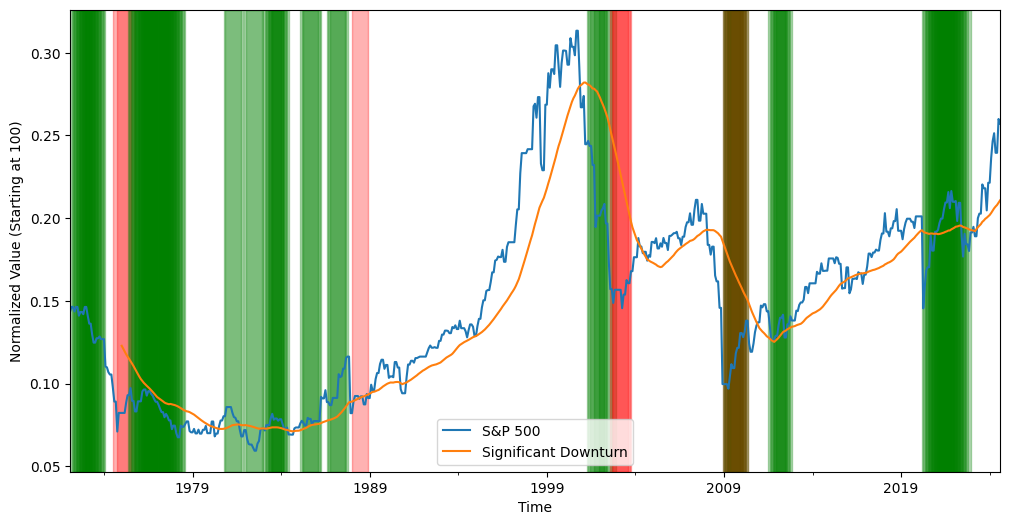

In [7]:
# plot overvalue and overvalue_12
ax = m2[["overvalue", "overvalue_n"]].plot(figsize=(12,6))
for index, row in m2.iterrows():
    if row['Significant_Drop']:
        ax.axvspan(index, index + pd.Timedelta(days=365), color='red', alpha=0.3)
    if row['M2_increase']:
        ax.axvspan(index, index + pd.Timedelta(days=365), color='green', alpha=0.3)

plt.xlabel('Time')
plt.ylabel('Normalized Value (Starting at 100)')
plt.legend(['S&P 500', 'Significant Downturn'])
plt.show()

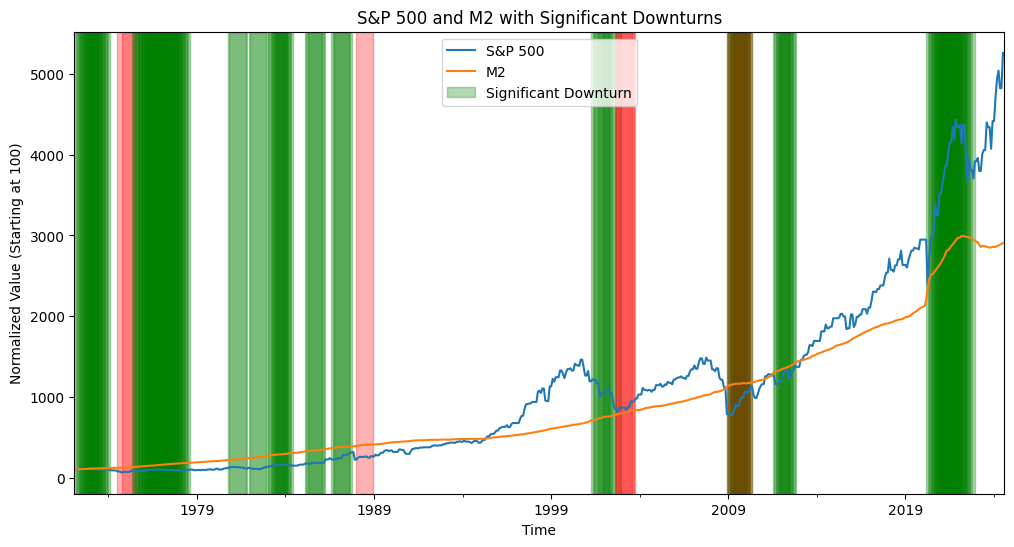

In [11]:
ax = m2[['S&P_100', 'M2_100']].plot(logy=False, figsize=(12,6), title='S&P 500 and M2 with Significant Downturns')

for index, row in m2.iterrows():
    if row['Significant_Drop']:
        ax.axvspan(index, index + pd.Timedelta(days=365), color='red', alpha=0.3)
    if row['M2_increase']:
        ax.axvspan(index, index + pd.Timedelta(days=365), color='green', alpha=0.3)

plt.xlabel('Time')
plt.ylabel('Normalized Value (Starting at 100)')
plt.legend(['S&P 500', 'M2', 'Significant Downturn'])
plt.show()

In [9]:
# simulate what happens if you invest in the s&p when overvalue is above overvalue_n and sell otherwise

initial_balance = 100
balance = initial_balance
current_trade = 0
balances = []

for i in range(1, len(m2)):
    # Check for missing or None values
    if pd.isna(m2["overvalue_n"][i]) or pd.isna(m2["overvalue"][i]) or pd.isna(m2['S&P'][i]) or pd.isna(m2['S&P'][i-1]):
        continue

    # Avoid division by zero
    if m2['S&P'][i-1] == 0:
        continue

    change = (m2['S&P'][i] - m2['S&P'][i-1]) / m2['S&P'][i-1]

    if m2['overvalue'][i] > m2['overvalue_n'][i]:
        # Buy
        trade_size = 0.1 * balance
        balance -= trade_size
        current_trade += trade_size / m2['S&P'][i]
    else:
        # Sell
        sell_amount = 0.1 * current_trade  # Units of the asset to sell
        trade_size = sell_amount * m2['S&P'][i]  # Cash received
        balance += trade_size
        current_trade -= sell_amount
        print(balance)

    # Update total portfolio value
    total_value = balance + current_trade * m2['S&P'][i]
    print(total_value)
    balances.append(total_value)

print(balance)

100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
82.68643151448846
97.8643151448846
84.25294119249315
98.35152829453544
85.66279990269739
98.35152829453546
99.49093920296556
100.714613834778
100.714613834778
102.58357855106354
102.58357855106354
106.70664994086181
106.70664994086182
106.70664994086184
10

/var/folders/60/df0y9d9s5rjfqhlhkzn3l6p40000gn/T/ipykernel_65985/1266297970.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isna(m2["overvalue_n"][i]) or pd.isna(m2["overvalue"][i]) or pd.isna(m2['S&P'][i]) or pd.isna(m2['S&P'][i-1]):
/var/folders/60/df0y9d9s5rjfqhlhkzn3l6p40000gn/T/ipykernel_65985/1266297970.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if m2['S&P'][i-1] == 0:
/var/folders/60/df0y9d9s5rjfqhlhkzn3l6p40000gn/T/ipykernel_65985/1266297970.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels

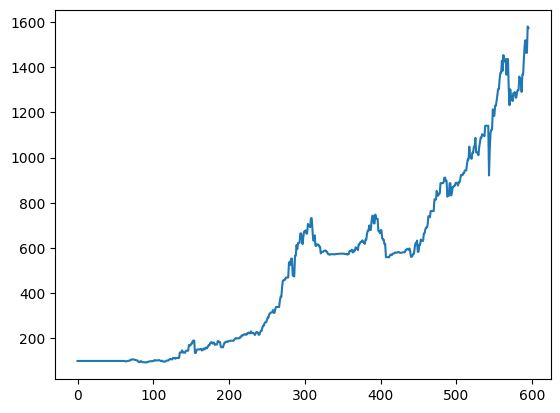

In [10]:
# plot balances
import matplotlib.pyplot as plt
plt.plot(balances)
plt.show()